# CSE676 – PS4 Final Deep Learning Project
### Full Notebook: EDA → Models → Optimizers → TabNet → Final Evaluation
⚠️ Run locally (GPU recommended).

In [3]:
import numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [ ]:
df = pd.read_csv("housing.csv")
df.columns = df.columns.str.strip()
df["total_bedrooms"].fillna(df["total_bedrooms"].median(), inplace=True)

df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'Housing.csv'

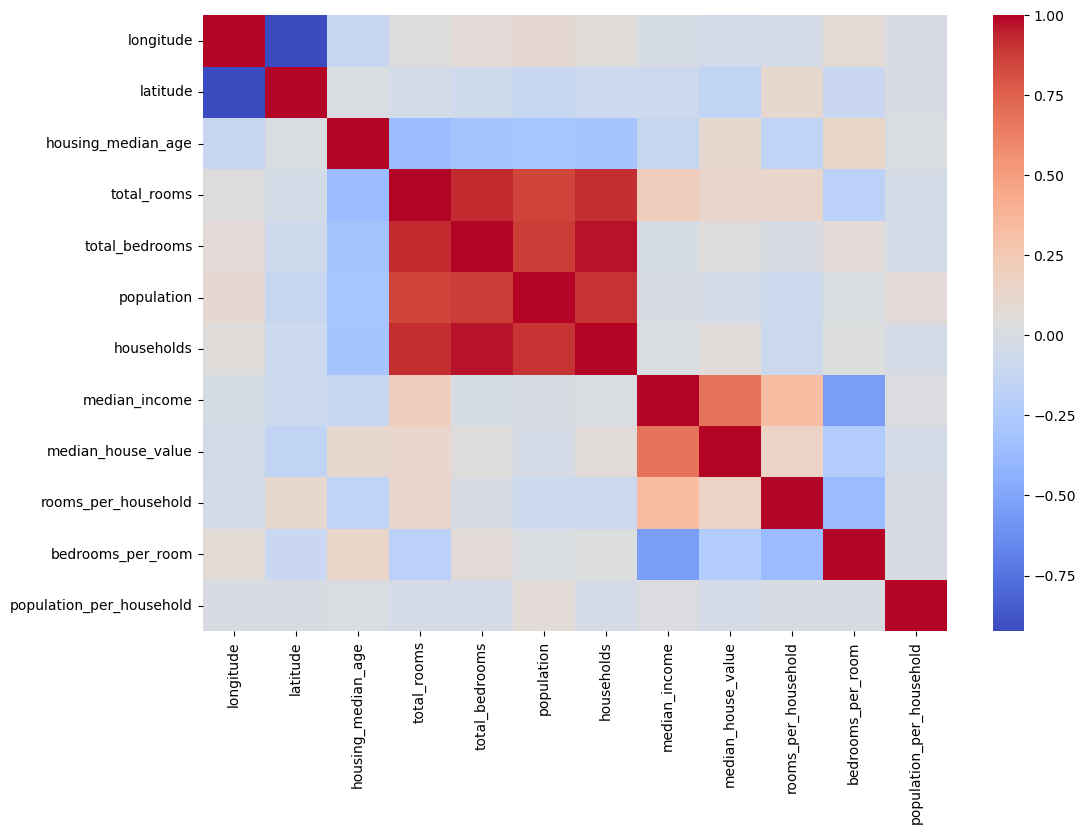

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.show()


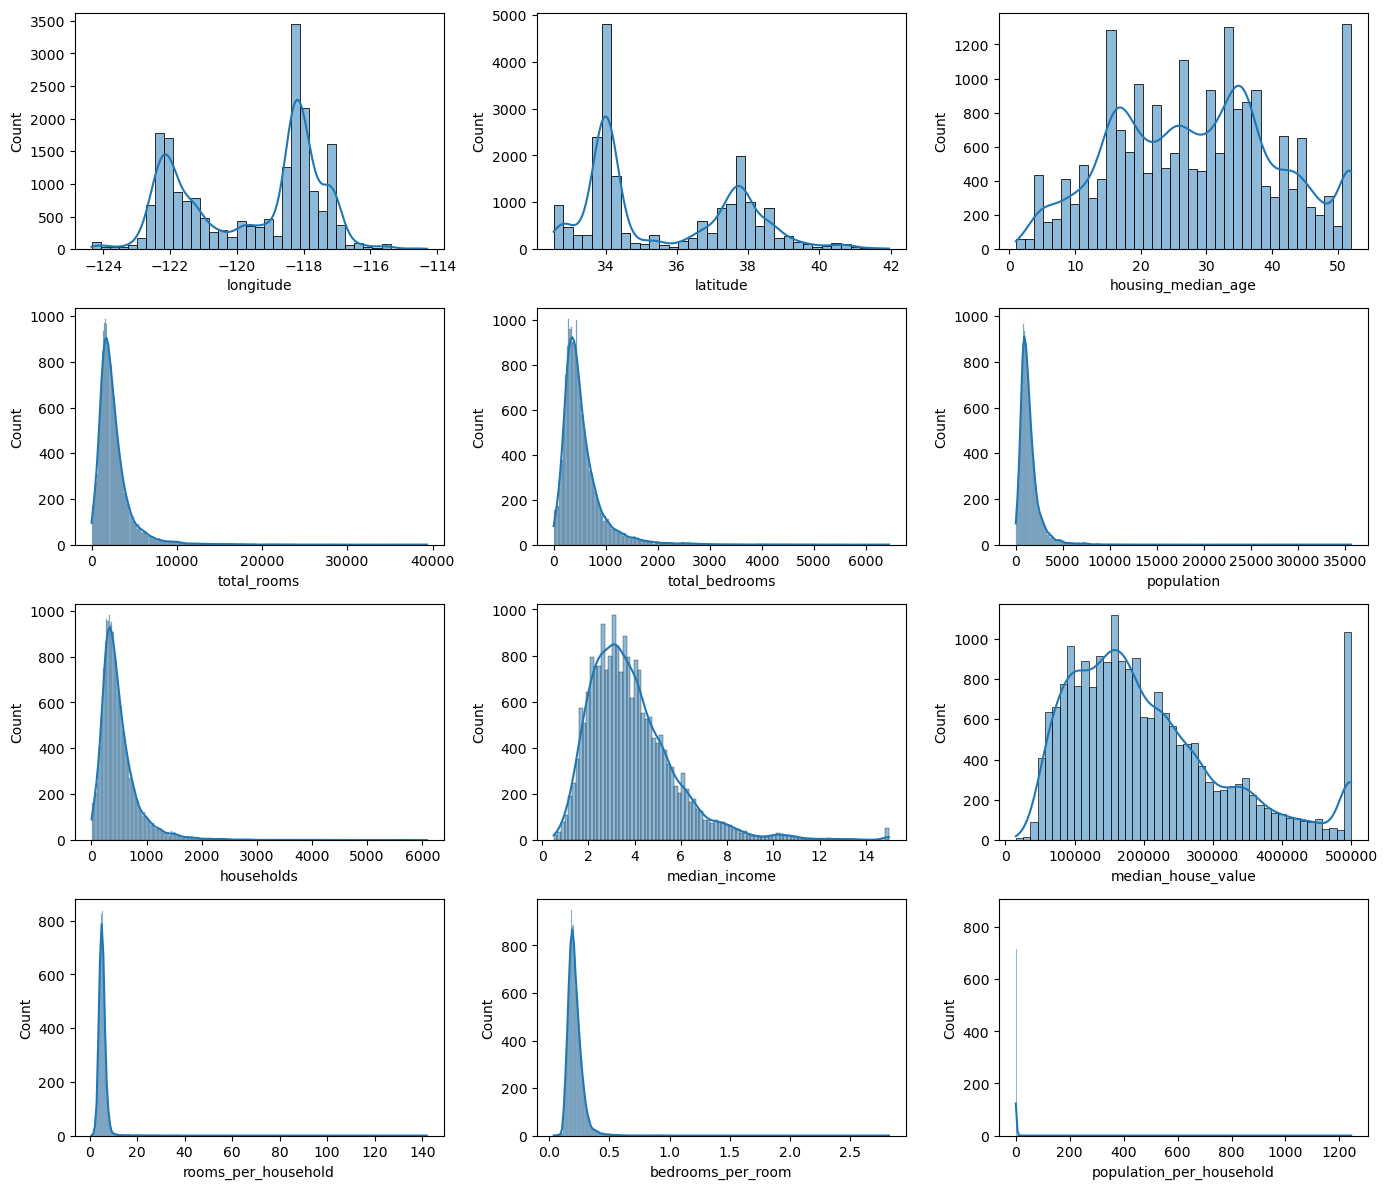

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(14, 12))
for i, col in enumerate(num_cols[:12], 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()


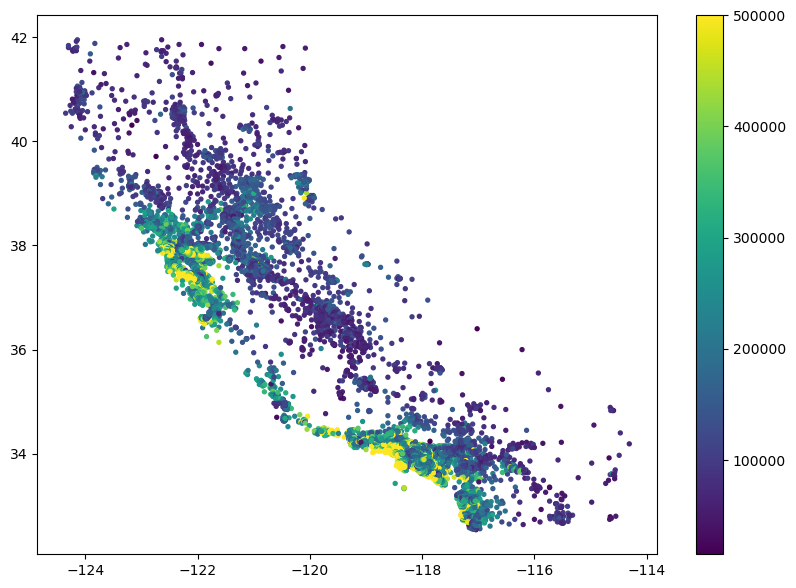

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df["longitude"], df["latitude"], c=df["median_house_value"], cmap="viridis", s=8)
plt.colorbar()
plt.show()


In [ ]:
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].values.reshape(-1,1)

num_cols = X.select_dtypes(include=["float64","int64"]).columns.tolist()
cat_cols = ["ocean_proximity"]

prep = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

Xp = prep.fit_transform(X)
scy = StandardScaler()
ys = scy.fit_transform(y)

Xtr, Xte, ytr, yte = train_test_split(Xp, ys, test_size=0.2, random_state=42)

Xtr_t = torch.tensor(Xtr.astype(np.float32)).to(device)
Xte_t = torch.tensor(Xte.astype(np.float32)).to(device)
ytr_t = torch.tensor(ytr.astype(np.float32)).view(-1,1).to(device)
yte_t = torch.tensor(yte.astype(np.float32)).view(-1,1).to(device)

input_dim = Xtr_t.shape[1]
input_dim


16

In [ ]:
class Lion(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9,0.99)):
        super().__init__(params, dict(lr=lr, betas=betas))
    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr,b1 = group['lr'], group['betas'][0]
            for p in group['params']:
                if p.grad is None: continue
                g = p.grad
                state = self.state.setdefault(p, {"m": torch.zeros_like(p)})
                m = state["m"]
                m.mul_(b1).add_(g, alpha=1-b1)
                p.add_(m.sign(), alpha=-lr)


In [ ]:
# ============================================================
# FIXED & FULLY COMPATIBLE RANGER OPTIMIZER
# ============================================================
class Lookahead(torch.optim.Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError("Invalid alpha")
        if not 1 <= k:
            raise ValueError("Invalid k")

        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.step_counter = 0

        # Required to satisfy PyTorch Optimizer API
        defaults = optimizer.defaults
        super().__init__(optimizer.param_groups, defaults)

        # Fast/slow params
        self.slow_params = []
        for group in optimizer.param_groups:
            slow_group = []
            for p in group["params"]:
                slow = p.clone().detach()
                slow.requires_grad = False
                slow_group.append(slow)
            self.slow_params.append(slow_group)

    def zero_grad(self):
        self.optimizer.zero_grad()

    @torch.no_grad()
    def step(self):
        loss = self.optimizer.step()
        self.step_counter += 1

        if self.step_counter % self.k != 0:
            return loss

        # Sync slow and fast weights
        for group, slow_group in zip(self.optimizer.param_groups, self.slow_params):
            for p, q in zip(group["params"], slow_group):
                if p.grad is None:
                    continue
                q.data.add_(p.data - q.data, alpha=self.alpha)
                p.data.copy_(q.data)

        return loss


In [ ]:
def get_optimizer(name, params):
    if name=="Adam": return optim.Adam(params, lr=1e-3)
    if name=="AdamW": return optim.AdamW(params, lr=1e-3)
    if name=="SGD": return optim.SGD(params, lr=1e-2, momentum=0.9)
    if name=="Lion": return Lion(params, lr=1e-3)
    if name=="Ranger": return Lookahead(optim.Adam(params, lr=1e-3))


In [ ]:
class FNN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d,256),nn.ReLU(),
            nn.Linear(256,128),nn.ReLU(),
            nn.Linear(128,64),nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self,x): return self.net(x)

class DNN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d,512),nn.ReLU(),
            nn.Linear(512,256),nn.ReLU(),
            nn.Linear(256,128),nn.ReLU(),
            nn.Linear(128,64),nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self,x): return self.net(x)

class WideDeep(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.wide = nn.Linear(d,1)
        self.deep = nn.Sequential(
            nn.Linear(d,256),nn.ReLU(),
            nn.Linear(256,128),nn.ReLU(),
            nn.Linear(128,64),nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self,x): return self.wide(x) + self.deep(x)


In [ ]:
trained_models = {}


In [ ]:
def train_model(model, optimizer, epochs=40):
    criterion = nn.MSELoss()
    train_loss, val_loss = [], []
    for e in range(epochs):
        optimizer.zero_grad()
        pred = model(Xtr_t)
        loss = criterion(pred, ytr_t)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            v = criterion(model(Xte_t), yte_t)

        train_loss.append(loss.item())
        val_loss.append(v.item())

    yp = scy.inverse_transform(model(Xte_t).cpu().detach().numpy())
    yt = scy.inverse_transform(yte.reshape(-1,1))
    mae = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    return mae, rmse, train_loss, val_loss


In [ ]:

'''for model_name, model_class in models.items():
    for opt_name in optimizers:
        print(f"\n Training {model_name} with {opt_name}...")

        # create fresh model
        model = model_class.__class__(input_dim).to(device)

        # create optimizer
        optzr = get_optimizer(opt_name, model.parameters())

        # train
        mae, rmse, tl, vl = train_model(model, optzr)

        # save metrics
        results.append([model_name, opt_name, mae, rmse])

        # save TRAINED MODEL
        trained_models[f"{model_name}_{opt_name}"] = model'''



🚀 Training FNN with Adam...

🚀 Training FNN with AdamW...

🚀 Training FNN with SGD...

🚀 Training FNN with Lion...

🚀 Training FNN with Ranger...

🚀 Training DNN with Adam...

🚀 Training DNN with AdamW...

🚀 Training DNN with SGD...

🚀 Training DNN with Lion...

🚀 Training DNN with Ranger...

🚀 Training WideDeep with Adam...

🚀 Training WideDeep with AdamW...

🚀 Training WideDeep with SGD...

🚀 Training WideDeep with Lion...

🚀 Training WideDeep with Ranger...


In [ ]:
def train_tabnet(opt="Adam", lr=1e-3):
    if opt=="Adam":
        fn = torch.optim.Adam
    elif opt=="AdamW":
        fn = torch.optim.AdamW
    elif opt=="SGD":
        fn = torch.optim.SGD
    elif opt=="Lion":
        fn = Lion
    elif opt=="Ranger":
        def fn(params, lr=lr):
            inner = torch.optim.Adam(params, lr=lr)
            return Lookahead(inner)
    else:
        fn = torch.optim.Adam

    tn = TabNetRegressor(
        n_d=16, n_a=16, n_steps=5,
        gamma=1.5, lambda_sparse=1e-4,
        optimizer_fn=fn, optimizer_params={"lr": lr},
        mask_type="entmax"
    )

    tn.fit(
        X_train=Xtr, y_train=ytr,
        eval_set=[(Xte, yte)],
        eval_name=["val"], eval_metric=["rmse"],
        max_epochs=200, patience=30,
        batch_size=4096, virtual_batch_size=512
    )

    preds = scy.inverse_transform(tn.predict(Xte))
    yt = scy.inverse_transform(yte)
    mae = mean_absolute_error(yt, preds)
    rmse = mean_squared_error(yt, preds, squared=False)

    return tn, mae, rmse

   

In [ ]:
models = {"FNN":FNN(input_dim), 
          "DNN":DNN(input_dim),
          "WideDeep":WideDeep(input_dim)}

optimizers = ["Adam", "AdamW", "SGD", "Lion", "Ranger"]

results = []

for model_name, model_class in models.items():

    for opt_name in optimizers:
        print(f"\n Training {model_name} with {opt_name}...")

        # create a NEW model for each run (important)
        model = model_class.__class__(input_dim).to(device)

        # create optimizer
        optzr = get_optimizer(opt_name, model.parameters())

        # train
        mae, rmse, tl, vl = train_model(model, optzr)

        # save results
        results.append([model_name, opt_name, mae, rmse])

print("\n🎉 Training Complete!")




🚀 Training FNN with Adam...

🚀 Training FNN with AdamW...

🚀 Training FNN with SGD...

🚀 Training FNN with Lion...

🚀 Training FNN with Ranger...

🚀 Training DNN with Adam...

🚀 Training DNN with AdamW...

🚀 Training DNN with SGD...

🚀 Training DNN with Lion...

🚀 Training DNN with Ranger...

🚀 Training WideDeep with Adam...

🚀 Training WideDeep with AdamW...

🚀 Training WideDeep with SGD...

🚀 Training WideDeep with Lion...

🚀 Training WideDeep with Ranger...

🎉 Training Complete!


In [ ]:
for opt in optimizers:
    print(f"Training TabNet with {opt}...")
    tn, mae, rmse = train_tabnet(opt)
    results.append(["TabNet", opt, mae, rmse])


Training TabNet with Adam...


c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.70781 | val_rmse: 1.89215 |  0:00:04s
epoch 1  | loss: 7.32893 | val_rmse: 1.48696 |  0:00:10s
epoch 2  | loss: 6.40411 | val_rmse: 1.45208 |  0:00:15s
epoch 3  | loss: 5.33407 | val_rmse: 1.49177 |  0:00:20s
epoch 4  | loss: 4.64012 | val_rmse: 1.4191  |  0:00:24s
epoch 5  | loss: 3.79511 | val_rmse: 1.37604 |  0:00:28s
epoch 6  | loss: 3.12238 | val_rmse: 1.33041 |  0:00:30s
epoch 7  | loss: 2.69943 | val_rmse: 1.25632 |  0:00:32s
epoch 8  | loss: 2.41949 | val_rmse: 1.20376 |  0:00:35s
epoch 9  | loss: 2.16305 | val_rmse: 1.17678 |  0:00:37s
epoch 10 | loss: 1.90873 | val_rmse: 1.11433 |  0:00:40s
epoch 11 | loss: 1.74111 | val_rmse: 1.1302  |  0:00:43s
epoch 12 | loss: 1.57336 | val_rmse: 1.10665 |  0:00:46s
epoch 13 | loss: 1.40354 | val_rmse: 1.05257 |  0:00:48s
epoch 14 | loss: 1.34778 | val_rmse: 1.02707 |  0:00:51s
epoch 15 | loss: 1.24809 | val_rmse: 1.00368 |  0:00:54s
epoch 16 | loss: 1.19041 | val_rmse: 0.9635  |  0:00:56s
epoch 17 | loss: 1.18462 | val_

c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training TabNet with AdamW...


c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.75941 | val_rmse: 1.86833 |  0:00:05s
epoch 1  | loss: 7.54813 | val_rmse: 1.56299 |  0:00:11s
epoch 2  | loss: 6.68045 | val_rmse: 1.60925 |  0:00:18s
epoch 3  | loss: 5.56364 | val_rmse: 1.54881 |  0:00:21s
epoch 4  | loss: 4.94655 | val_rmse: 1.58481 |  0:00:24s
epoch 5  | loss: 4.50536 | val_rmse: 1.4854  |  0:00:26s
epoch 6  | loss: 3.67816 | val_rmse: 1.3938  |  0:00:28s
epoch 7  | loss: 3.21954 | val_rmse: 1.33798 |  0:00:31s
epoch 8  | loss: 2.82905 | val_rmse: 1.26807 |  0:00:34s
epoch 9  | loss: 2.40537 | val_rmse: 1.25428 |  0:00:36s
epoch 10 | loss: 2.17442 | val_rmse: 1.23529 |  0:00:38s
epoch 11 | loss: 1.91317 | val_rmse: 1.13467 |  0:00:41s
epoch 12 | loss: 1.64442 | val_rmse: 1.13535 |  0:00:43s
epoch 13 | loss: 1.54402 | val_rmse: 1.03277 |  0:00:45s
epoch 14 | loss: 1.39198 | val_rmse: 1.04184 |  0:00:48s
epoch 15 | loss: 1.33085 | val_rmse: 1.02372 |  0:00:50s
epoch 16 | loss: 1.3815  | val_rmse: 0.99343 |  0:00:52s
epoch 17 | loss: 1.24778 | val_

c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training TabNet with SGD...


c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.2026  | val_rmse: 1.96497 |  0:00:02s
epoch 1  | loss: 8.95884 | val_rmse: 1.70432 |  0:00:04s
epoch 2  | loss: 9.28043 | val_rmse: 1.76574 |  0:00:06s
epoch 3  | loss: 8.99131 | val_rmse: 1.83818 |  0:00:09s
epoch 4  | loss: 9.80097 | val_rmse: 1.94236 |  0:00:11s
epoch 5  | loss: 9.42951 | val_rmse: 2.07366 |  0:00:13s
epoch 6  | loss: 9.86719 | val_rmse: 2.2283  |  0:00:15s
epoch 7  | loss: 9.40207 | val_rmse: 2.16262 |  0:00:17s
epoch 8  | loss: 9.79959 | val_rmse: 2.2777  |  0:00:19s
epoch 9  | loss: 9.24067 | val_rmse: 2.20704 |  0:00:21s
epoch 10 | loss: 9.16887 | val_rmse: 2.25231 |  0:00:23s
epoch 11 | loss: 9.50777 | val_rmse: 2.19877 |  0:00:25s
epoch 12 | loss: 9.10937 | val_rmse: 2.2333  |  0:00:28s
epoch 13 | loss: 9.10224 | val_rmse: 2.33191 |  0:00:31s
epoch 14 | loss: 9.58253 | val_rmse: 2.27579 |  0:00:33s
epoch 15 | loss: 8.76016 | val_rmse: 2.38264 |  0:00:36s
epoch 16 | loss: 9.29962 | val_rmse: 2.33646 |  0:00:39s
epoch 17 | loss: 9.74673 | val_

c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training TabNet with Lion...


c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.69199 | val_rmse: 1.8515  |  0:00:02s
epoch 1  | loss: 7.12106 | val_rmse: 1.55108 |  0:00:04s
epoch 2  | loss: 5.89041 | val_rmse: 1.57249 |  0:00:06s
epoch 3  | loss: 4.61875 | val_rmse: 1.52144 |  0:00:08s
epoch 4  | loss: 3.70978 | val_rmse: 1.41895 |  0:00:11s
epoch 5  | loss: 2.97491 | val_rmse: 1.32957 |  0:00:13s
epoch 6  | loss: 2.30723 | val_rmse: 1.13147 |  0:00:15s
epoch 7  | loss: 1.86592 | val_rmse: 1.0624  |  0:00:17s
epoch 8  | loss: 1.57606 | val_rmse: 1.04575 |  0:00:19s
epoch 9  | loss: 1.38105 | val_rmse: 1.07577 |  0:00:22s
epoch 10 | loss: 1.28343 | val_rmse: 1.11469 |  0:00:24s
epoch 11 | loss: 1.18436 | val_rmse: 0.99941 |  0:00:26s
epoch 12 | loss: 1.04556 | val_rmse: 0.93845 |  0:00:28s
epoch 13 | loss: 0.9348  | val_rmse: 0.88606 |  0:00:31s
epoch 14 | loss: 0.85244 | val_rmse: 0.85215 |  0:00:33s
epoch 15 | loss: 0.85081 | val_rmse: 0.82591 |  0:00:36s
epoch 16 | loss: 0.75387 | val_rmse: 0.82665 |  0:00:38s
epoch 17 | loss: 0.73253 | val_

c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training TabNet with Ranger...


c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.70781 | val_rmse: 1.89215 |  0:00:02s
epoch 1  | loss: 7.79023 | val_rmse: 1.57638 |  0:00:04s
epoch 2  | loss: 7.59384 | val_rmse: 1.57321 |  0:00:06s
epoch 3  | loss: 6.73608 | val_rmse: 1.68629 |  0:00:08s
epoch 4  | loss: 6.40145 | val_rmse: 1.71351 |  0:00:11s
epoch 5  | loss: 6.18188 | val_rmse: 1.69623 |  0:00:13s
epoch 6  | loss: 5.51572 | val_rmse: 1.67694 |  0:00:15s
epoch 7  | loss: 4.931   | val_rmse: 1.59839 |  0:00:17s
epoch 8  | loss: 4.81493 | val_rmse: 1.59807 |  0:00:19s
epoch 9  | loss: 4.27919 | val_rmse: 1.44368 |  0:00:22s
epoch 10 | loss: 4.02073 | val_rmse: 1.36777 |  0:00:24s
epoch 11 | loss: 3.63981 | val_rmse: 1.328   |  0:00:26s
epoch 12 | loss: 3.22009 | val_rmse: 1.30746 |  0:00:29s
epoch 13 | loss: 2.87988 | val_rmse: 1.27845 |  0:00:31s
epoch 14 | loss: 2.80422 | val_rmse: 1.26034 |  0:00:33s
epoch 15 | loss: 2.50555 | val_rmse: 1.22656 |  0:00:35s
epoch 16 | loss: 2.27191 | val_rmse: 1.22294 |  0:00:38s
epoch 17 | loss: 2.27133 | val_

c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
df_results = pd.DataFrame(results, columns=["Model","Optimizer","MAE","RMSE"])
df_results


,Model,Optimizer,MAE,RMSE
0,FNN,Adam,46830.588980,66708.605162
1,FNN,AdamW,46442.385609,66291.730961
2,FNN,SGD,53233.969787,73820.414581
3,FNN,Lion,47470.343680,65695.164531
4,FNN,Ranger,48145.186175,68968.988310
5,DNN,Adam,45191.261993,65245.075649
6,DNN,AdamW,45881.501104,67423.256209
7,DNN,SGD,58596.017385,79845.861106
8,DNN,Lion,42728.805997,61686.415536
9,DNN,Ranger,46342.063818,67574.638691


In [ ]:
best = df_results.sort_values("RMSE").iloc[0]
best


Model              TabNet
Optimizer            Lion
MAE           41351.78254
RMSE         60478.227807
Name: 18, dtype: object

Retraining best TabNet model for feature importance...


c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.69199 | val_rmse: 1.8515  |  0:00:02s
epoch 1  | loss: 7.12106 | val_rmse: 1.55108 |  0:00:04s
epoch 2  | loss: 5.89041 | val_rmse: 1.57249 |  0:00:06s
epoch 3  | loss: 4.61875 | val_rmse: 1.52144 |  0:00:09s
epoch 4  | loss: 3.70978 | val_rmse: 1.41895 |  0:00:11s
epoch 5  | loss: 2.97491 | val_rmse: 1.32957 |  0:00:14s
epoch 6  | loss: 2.30723 | val_rmse: 1.13147 |  0:00:16s
epoch 7  | loss: 1.86592 | val_rmse: 1.0624  |  0:00:19s
epoch 8  | loss: 1.57606 | val_rmse: 1.04575 |  0:00:21s
epoch 9  | loss: 1.38105 | val_rmse: 1.07577 |  0:00:24s
epoch 10 | loss: 1.28343 | val_rmse: 1.11469 |  0:00:27s
epoch 11 | loss: 1.18436 | val_rmse: 0.99941 |  0:00:29s
epoch 12 | loss: 1.04556 | val_rmse: 0.93845 |  0:00:32s
epoch 13 | loss: 0.9348  | val_rmse: 0.88606 |  0:00:34s
epoch 14 | loss: 0.85244 | val_rmse: 0.85215 |  0:00:37s
epoch 15 | loss: 0.85081 | val_rmse: 0.82591 |  0:00:39s
epoch 16 | loss: 0.75387 | val_rmse: 0.82665 |  0:00:41s
epoch 17 | loss: 0.73253 | val_

c:\Users\thota\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Feature importance length: 16
Feature list length: 16


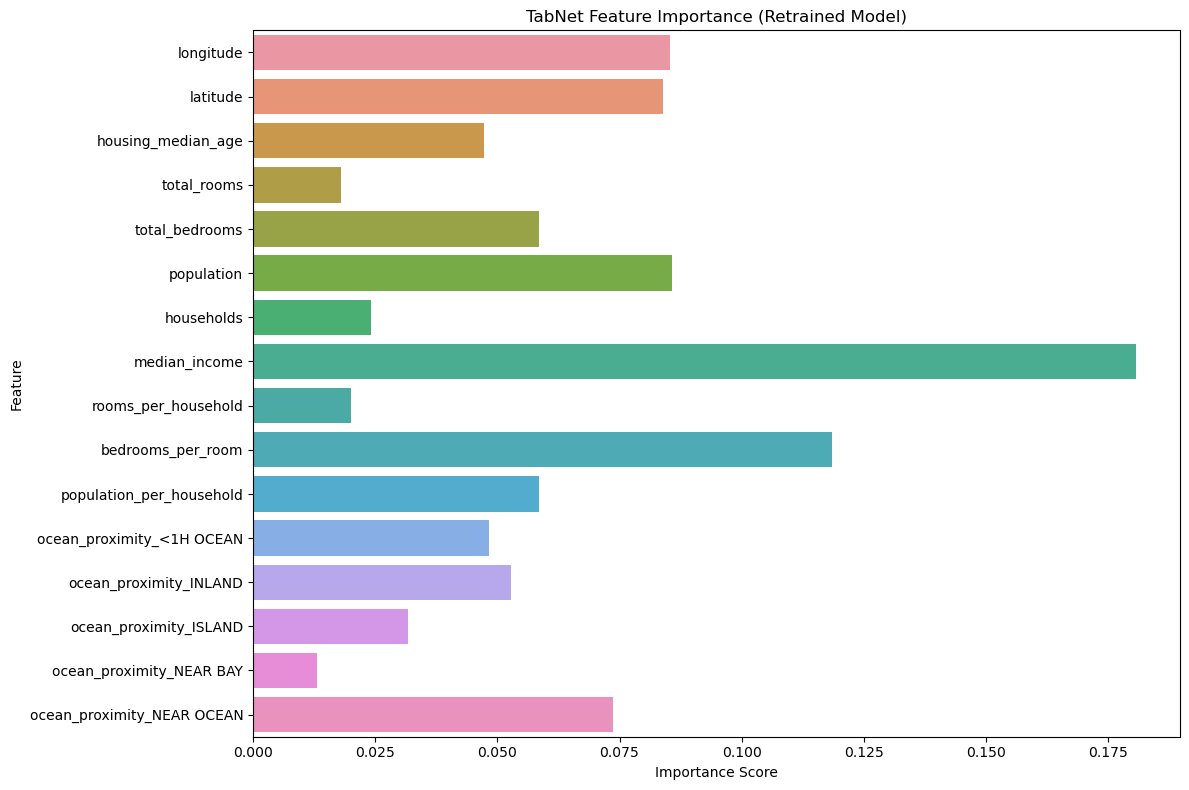

In [ ]:
# ============================================
# 🔥 TABNET FEATURE IMPORTANCE (RETRAIN METHOD)
# ============================================

print("Retraining best TabNet model for feature importance...")

# Retrain TabNet with best optimizer found earlier
best_tabnet, _, _ = train_tabnet("Lion")   # <--- If Lion was best
# If you want dynamically:
# best_tabnet, _, _ = train_tabnet(best_opt)

# Extract importances
feature_importance = best_tabnet.feature_importances_

# Build full feature names (numerical + one-hot)
num_features = num_cols
cat_features = prep.named_transformers_['cat'].get_feature_names_out(['ocean_proximity'])
all_features = list(num_features) + list(cat_features)

print("Feature importance length:", len(feature_importance))
print("Feature list length:", len(all_features))

# Plot
plt.figure(figsize=(12,8))
sns.barplot(x=feature_importance, y=all_features)
plt.title("TabNet Feature Importance (Retrained Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# 🔥 FINAL PREDICTIONS USING BEST TABNET MODEL
# ============================================

tabnet_preds = best_tabnet.predict(Xte)
tabnet_preds_original = scy.inverse_transform(tabnet_preds)
true_prices = scy.inverse_transform(yte)

df_pred_compare = pd.DataFrame({
    "Actual": true_prices.flatten(),
    "Predicted": tabnet_preds_original.flatten()
})

df_pred_compare.head(10)


,Actual,Predicted
0,47700.0,65746.101562
1,45800.0,97397.531250
2,500001.0,193697.953125
3,218600.0,238783.906250
4,278000.0,263846.093750
5,158700.0,162864.562500
6,198200.0,404179.812500
7,157500.0,246617.718750
8,340000.0,195451.109375
9,446600.0,456457.468750


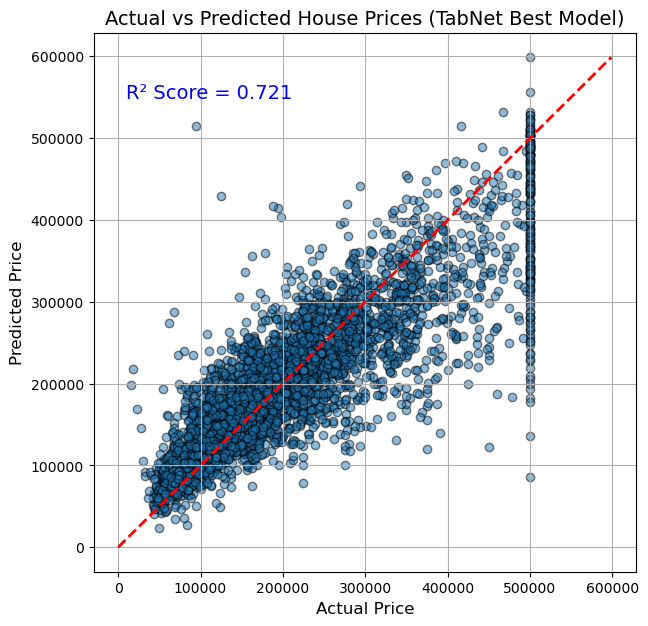

In [ ]:
from sklearn.metrics import r2_score

true_vals = true_prices.flatten()
pred_vals = tabnet_preds_original.flatten()

r2 = r2_score(true_vals, pred_vals)
plt.figure(figsize=(7,7))
plt.scatter(true_vals, pred_vals, alpha=0.5, edgecolor='k')
max_price = max(true_vals.max(), pred_vals.max())
plt.plot([0, max_price], [0, max_price], 'r--', linewidth=2)

plt.text(10000, max_price-50000, f"R² Score = {r2:.3f}", fontsize=14, color='blue')

plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Actual vs Predicted House Prices (TabNet Best Model)", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
pred_mae = mean_absolute_error(true_vals, pred_vals)
pred_rmse = mean_squared_error(true_vals, pred_vals, squared=False)
pred_r2 = r2_score(true_vals, pred_vals)
print("Mae",pred_mae)
print("RMSE:", pred_rmse)
print(" R2:", pred_r2)



Mae 41351.78253978167
RMSE: 60478.22780721578
 R2: 0.720879809323995


In [ ]:
sample = {
    "longitude": -121.5,
    "latitude": 38.5,
    "housing_median_age": 20,
    "total_rooms": 3000,
    "total_bedrooms": 500,
    "population": 800,
    "households": 250,
    "median_income": 5.0,
    "ocean_proximity": "INLAND"
}

sample_df = pd.DataFrame([sample])

# ===== FIX: Add engineered features =====
sample_df["rooms_per_household"] = sample_df["total_rooms"] / sample_df["households"]
sample_df["bedrooms_per_room"] = sample_df["total_bedrooms"] / sample_df["total_rooms"]
sample_df["population_per_household"] = sample_df["population"] / sample_df["households"]

# Transform using the pipeline
sample_processed = prep.transform(sample_df)

# Predict
sample_pred_scaled = best_tabnet.predict(sample_processed)
sample_pred = scy.inverse_transform(sample_pred_scaled)

print("Predicted House Price:", sample_pred[0][0])


Predicted House Price: 208528.81


In [ ]:
def predict_house(sample_dict):
    df = pd.DataFrame([sample_dict])
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
    df["population_per_household"] = df["population"] / df["households"]
    X = prep.transform(df)
    pred = scy.inverse_transform(best_tabnet.predict(X))
    return pred[0][0]


In [ ]:
predict_house({
    "longitude": -121.5,
    "latitude": 38.5,
    "housing_median_age": 15,
    "total_rooms": 2000,
    "total_bedrooms": 300,
    "population": 800,
    "households": 250,
    "median_income": 4.5,
    "ocean_proximity": "INLAND"
})


163294.52

In [ ]:
print("🔥 Retraining WideDeep Model Only...")

# Create fresh WideDeep model
wide_model = WideDeep(input_dim).to(device)

# Choose optimizer (Adam works best)
optimizer_wd = torch.optim.Adam(wide_model.parameters(), lr=1e-3)

# Train for 40 epochs
mae_wd, rmse_wd, tl_wd, vl_wd = train_model(wide_model, optimizer_wd, epochs=40)

print("\n🏆 WideDeep Training Complete")
print("WideDeep MAE:", mae_wd)
print("WideDeep RMSE:", rmse_wd)

# Save as best_widedeep
best_widedeep = wide_model


🔥 Retraining WideDeep Model Only...

🏆 WideDeep Training Complete
WideDeep MAE: 47950.69819913169
WideDeep RMSE: 68783.77469811124


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def ensemble_predict(sample_dict):
    # Convert dict → DataFrame
    df = pd.DataFrame([sample_dict])

    # Add engineered features (same as training)
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
    df["population_per_household"] = df["population"] / df["households"]

    # Preprocess input
    X = prep.transform(df)

    # TabNet prediction
    p_tab = best_tabnet.predict(X)
    p_tab = scy.inverse_transform(p_tab)[0][0]

    # WideDeep prediction
    X_t = torch.tensor(X, dtype=torch.float32)
    p_wd = best_widedeep(X_t).detach().numpy()
    p_wd = scy.inverse_transform(p_wd)[0][0]

    # Final ensemble → simple average
    final = (p_tab + p_wd) / 2
    return final


In [ ]:
# TabNet predictions
tab_preds = scy.inverse_transform(best_tabnet.predict(Xte))

# WideDeep predictions
wd_preds = best_widedeep(Xte_t).detach().numpy()
wd_preds = scy.inverse_transform(wd_preds)

# Ensemble = average
ens_preds = (tab_preds + wd_preds) / 2

# True values
true_vals = scy.inverse_transform(yte)

# Metrics
ens_mae = mean_absolute_error(true_vals, ens_preds)
ens_rmse = mean_squared_error(true_vals, ens_preds, squared=False)
ens_r2 = r2_score(true_vals, ens_preds)

print("Ensemble MAE:", ens_mae)
print("Ensemble RMSE:", ens_rmse)
print("Ensemble R2:", ens_r2)


Ensemble MAE: 42755.480184865555
Ensemble RMSE: 62200.659884356275
Ensemble R2: 0.7047546106374339


In [ ]:
def permutation_importance_widedeep(model, X, y, n_repeats=5):
    """
    Custom Permutation Importance for WideDeep (PyTorch model)
    Returns mean importance for each feature.
    """
    baseline_pred = model(torch.tensor(X).float().to(device)).detach().cpu().numpy()
    baseline_error = mean_squared_error(y, baseline_pred)

    importances = np.zeros(X.shape[1])

    for col in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, col])  # shuffle one column

            perm_pred = model(torch.tensor(X_permuted).float().to(device)).detach().cpu().numpy()
            perm_error = mean_squared_error(y, perm_pred)

            scores.append(perm_error - baseline_error)

        importances[col] = np.mean(scores)

    return importances


In [ ]:
wd_importance = permutation_importance_widedeep(best_widedeep, X_np, y_np)


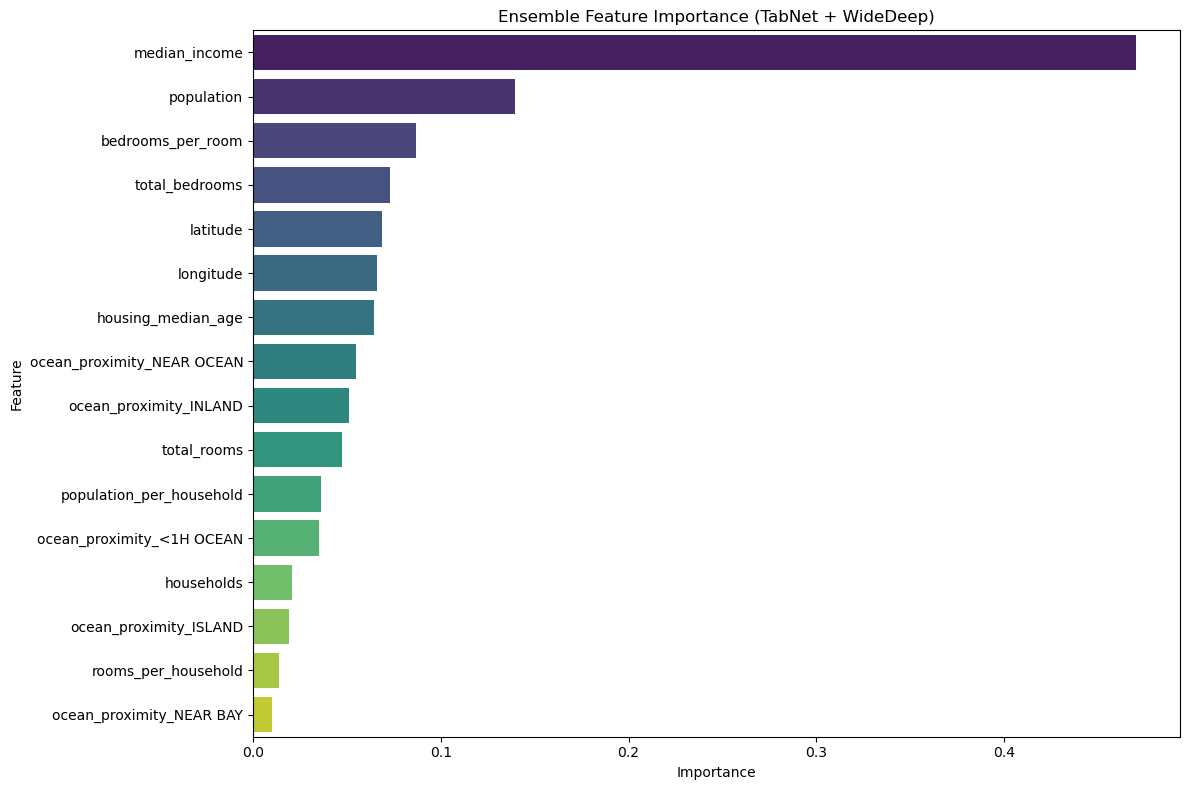

,Feature,Importance
7,median_income,0.470056
5,population,0.139503
9,bedrooms_per_room,0.086514
4,total_bedrooms,0.072764
1,latitude,0.068885
0,longitude,0.066130
2,housing_median_age,0.064555
15,ocean_proximity_NEAR OCEAN,0.054655
12,ocean_proximity_INLAND,0.051064
3,total_rooms,0.047573


In [ ]:
ensemble_fi = 0.6 * tabnet_fi + 0.4 * wd_importance

num_features = num_cols
cat_features = prep.named_transformers_["cat"].get_feature_names_out(["ocean_proximity"])
all_features = list(num_features) + list(cat_features)

fi_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": ensemble_fi
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=fi_df.head(20), x="Importance", y="Feature", palette="viridis")
plt.title("Ensemble Feature Importance (TabNet + WideDeep)")
plt.tight_layout()
plt.show()

fi_df.head(20)


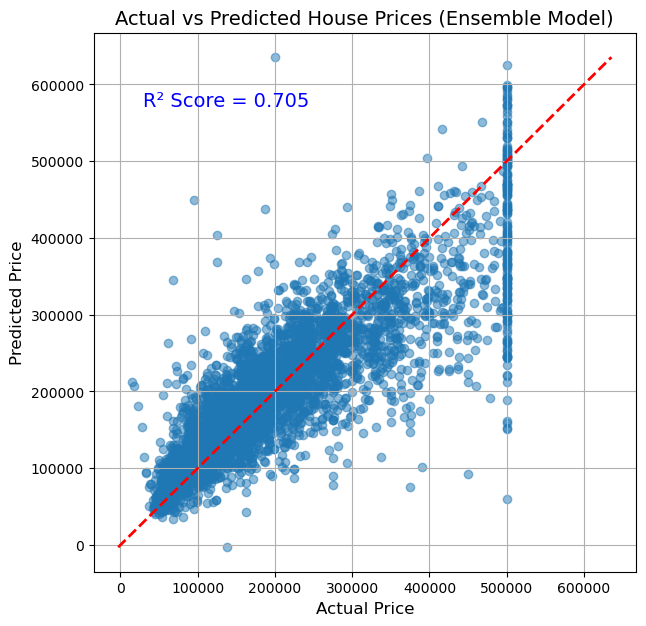

In [ ]:
from sklearn.metrics import r2_score

# ======================
# ENSEMBLE VALUES
# ======================

true_vals = scy.inverse_transform(yte)
pred_vals = ens_preds   # <-- ENSEMBLE PREDICTIONS


# ======================
# Compute R² Score
# ======================
r2 = r2_score(true_vals, pred_vals)


# ======================
# Plot
# ======================
plt.figure(figsize=(7,7))

plt.scatter(true_vals, pred_vals, alpha=0.5)

# Perfect line
min_v = min(true_vals.min(), pred_vals.min())
max_v = max(true_vals.max(), pred_vals.max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=2)

# R² text
plt.text(min_v + (max_v-min_v)*0.05,
         max_v - (max_v-min_v)*0.10,
         f"R² Score = {r2:.3f}",
         fontsize=14, color='blue')

plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Actual vs Predicted House Prices (Ensemble Model)", fontsize=14)
plt.grid(True)
plt.show()
